In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import re
from collections import Counter
from google.colab import files

In [2]:
# Upload CSV file manually
uploaded = files.upload()

Saving poems-100.csv to poems-100.csv


In [3]:
# Read the CSV file
df = pd.read_csv("poems-100.csv")

# Extract only the poems content
poems = df['text'].dropna().tolist()

# Convert to lowercase and remove special characters
cleaned_poems = [re.sub(r"[^a-zA-Z\s]", "", poem.lower()) for poem in poems]


In [22]:
# Tokenization
all_words = [word for poem in cleaned_poems for word in poem.split()]
vocab = sorted(set(all_words))
vocab_size = len(vocab)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}


In [23]:
# One-hot encoding function
def one_hot_encode(word_idx, vocab_size):
    vec = np.zeros(vocab_size)
    vec[word_idx] = 1
    return vec

In [24]:
# Prepare dataset
seq_length = 2
input_data = []
target_data = []
for poem in cleaned_poems:
    words = poem.split()
    for i in range(len(words) - seq_length):
        input_data.append([one_hot_encode(word_to_idx[words[j]], vocab_size) for j in range(i, i+seq_length)])
        target_data.append(word_to_idx[words[i + seq_length]])

X = torch.tensor(input_data, dtype=torch.float32)
y = torch.tensor(target_data, dtype=torch.long)

In [25]:
# Define LSTM Model with One-Hot Encoding
class LSTMOneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size):
        super(LSTMOneHot, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(vocab_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [26]:
# Initialize model
hidden_size = 16
model = LSTMOneHot(vocab_size, hidden_size, vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [27]:
# Training loop
epochs = 500
losses = []
accuracies = []

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Compute accuracy
    _, predicted = torch.max(output, 1)
    accuracy = (predicted == y).float().mean().item()
    accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

Epoch 10/500, Loss: 8.2314, Accuracy: 0.0019
Epoch 20/500, Loss: 7.2306, Accuracy: 0.0037
Epoch 30/500, Loss: 6.6897, Accuracy: 0.0728
Epoch 40/500, Loss: 6.4802, Accuracy: 0.0728
Epoch 50/500, Loss: 6.4076, Accuracy: 0.0728
Epoch 60/500, Loss: 6.3085, Accuracy: 0.0738
Epoch 70/500, Loss: 6.2111, Accuracy: 0.0731
Epoch 80/500, Loss: 6.0897, Accuracy: 0.0734
Epoch 90/500, Loss: 5.9319, Accuracy: 0.0754
Epoch 100/500, Loss: 5.7347, Accuracy: 0.0888
Epoch 110/500, Loss: 5.5033, Accuracy: 0.1122
Epoch 120/500, Loss: 5.2425, Accuracy: 0.1381
Epoch 130/500, Loss: 4.9616, Accuracy: 0.1681
Epoch 140/500, Loss: 4.6779, Accuracy: 0.1988
Epoch 150/500, Loss: 4.4050, Accuracy: 0.2357
Epoch 160/500, Loss: 4.1498, Accuracy: 0.2720
Epoch 170/500, Loss: 3.9150, Accuracy: 0.3078
Epoch 180/500, Loss: 3.7015, Accuracy: 0.3442
Epoch 190/500, Loss: 3.5086, Accuracy: 0.3780
Epoch 200/500, Loss: 3.3351, Accuracy: 0.4037
Epoch 210/500, Loss: 3.1791, Accuracy: 0.4308
Epoch 220/500, Loss: 3.0392, Accuracy: 0.45

In [28]:
# Save model weights
torch.save(model.state_dict(), "lstm_one_hot_weights.pth")
print("Model weights saved as lstm_one_hot_weights.pth")

Model weights saved as lstm_one_hot_weights.pth


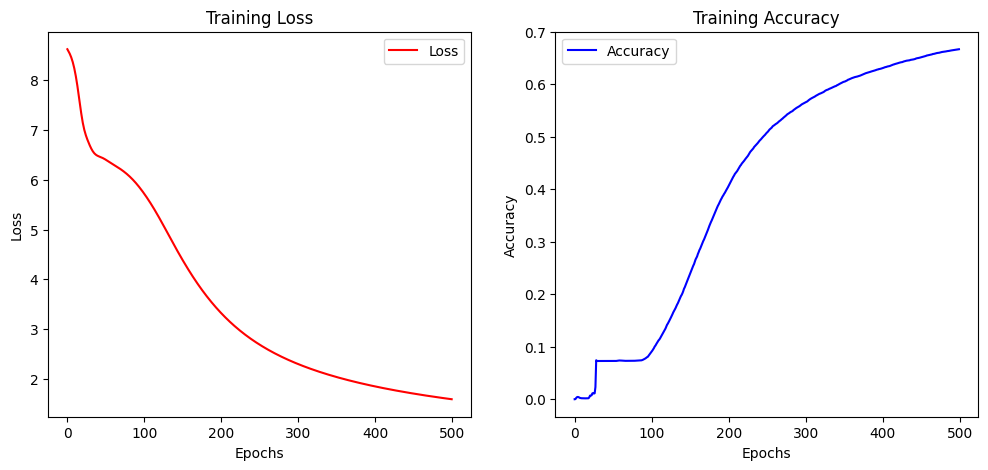

In [29]:
# Plot Loss and Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [30]:
# Generate text
def generate_text(start_word, length=5):
    model.eval()
    words = [start_word]
    for _ in range(length):
        input_seq = torch.tensor([one_hot_encode(word_to_idx[words[-1]], vocab_size)], dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            output = model(input_seq)
            next_word = idx_to_word[torch.argmax(output).item()]
        words.append(next_word)
    return ' '.join(words)

print("Generated Text:", generate_text("love"))


Generated Text: love oh was proved left shall
